# Revealing representative "typical" day-types using traffic data observation and clustering

This exercise can be divided to two parts. Both give you the toolsets of methods for exploring, visualazing and evaluating day clusterings.

## Data preparation

In [138]:
import pandas as pd
import numpy as np
#upload the dataset by downloading both datasets from canvas and upload it on colab

data_df = pd.read_csv("dataset_exercise_5_clustering_highway_traffic.csv",sep=";")
data_df

,PORTAL,Date,time_from,time_to,Interval_5,SPEED_MS_AVG,flow
0,"E4S 56,780",20210101,00:00:00,00:05:00,0,18.56,39
1,"E4S 56,780",20210101,00:05:00,00:10:00,1,20.39,18
2,"E4S 56,780",20210101,00:10:00,00:15:00,2,19.27,26
3,"E4S 56,780",20210101,00:15:00,00:20:00,3,19.52,52
4,"E4S 56,780",20210101,00:20:00,00:25:00,4,20.52,52
...,...,...,...,...,...,...,...
104838,"E4S 56,780",20211231,23:35:00,23:40:00,283,19.58,115
104839,"E4S 56,780",20211231,23:40:00,23:45:00,284,19.47,87
104840,"E4S 56,780",20211231,23:45:00,23:50:00,285,19.77,130
104841,"E4S 56,780",20211231,23:50:00,23:55:00,286,18.79,129


Your objective here is to reveal representative day-type clusters; hence, we cluster days. The provided dataset is 5-minute observations on highway microwave sensors and needs to be in a format ready for day clustering. Thus, we represent days as ordered vectors of day-time observations of size 288 (there are 288, 5-minute time observations)

In [139]:
# Sort the DataFrame 'data_df' by columns "Date" and "Interval_5"
data_df.sort_values(["Date", "Interval_5"])

# Extract unique dates from the sorted DataFrame
days = np.unique(data_df[['Date']].values.ravel())
# Calculate the total number of unique days
ndays = len(days)
print(ndays)

# Group the DataFrame 'data_df' by the "Date" column
day_subsets_df = data_df.groupby(["Date"])

# Define the total number of 5-minute intervals in a day
nintvals = 288

# Create a matrix 'vectorized_day_dataset' filled with NaN values
vectorized_day_dataset = np.zeros((ndays, nintvals))
vectorized_day_dataset.fill(np.nan)

# Loop through each unique day
for i in range(0, ndays):
    # Get the DataFrame corresponding to the current day
    df_t = day_subsets_df.get_group(days[i])

    # Loop through each row in the current day's DataFrame
    for j in range(len(df_t)):
        # Get the current day's DataFrame
        df_t = day_subsets_df.get_group(days[i])

        # Extract the "Interval_5" and "flow" values and populate 'vectorized_day_dataset'
        vectorized_day_dataset[i, df_t.iloc[j]["Interval_5"]] = df_t.iloc[j]["flow"]

# Print the resulting 'vectorized_day_dataset'
print(vectorized_day_dataset)

365
[[ 39.  18.  26. ...  32.  39.  34.]
 [ 30.  32.  27. ...  44.  41.  39.]
 [ 36.  44.  52. ...  50.  45.  23.]
 ...
 [ 20.  34.  31. ...  38.  42.  36.]
 [ 36.  40.  25. ...  38.  56.  35.]
 [ 33.  32.  34. ... 130. 129. 117.]]


* STEP 1: We ensure the ordering of days and intervals is proper. The data integer representation and indexing of time intervals allow a simple order of data.
* STEP 2: We get all unique days in the dataset to know the number and their list
* STEP 3: We could do the same of time-intervals, but here we know it is 288
* STEP 4: We create new datasets where rows are days and columns are day-time interval observations. *Note that if you plan to reveal network-wide day-types, this day vector can be ordered vector of SENSORS * TIME-INTERVALS.*
* STEP 5: fill in data to the right indexes.

# Part 1: Data exploration

It is always good practice to explore data you work with for outliers or pattern existence, as it can impact the revealed patterns and their predictions.

In [140]:
import numpy as np
from scipy import stats
print('number of nans',np.sum(np.isnan(vectorized_day_dataset)))
print('rate of nans',np.sum(np.isnan(vectorized_day_dataset))/(ndays*nintvals))

# Outlier detection using Z-score
z_scores = np.abs(stats.zscore(vectorized_day_dataset, nan_policy='omit'))  # omits NaNs in calculation
outliers = z_scores > 3  # Typically, a Z-score > 3 is considered an outlier

print('Number of outliers:', np.sum(outliers))
print('Outliers as a percentage of total data:', np.sum(outliers) / vectorized_day_dataset.size * 100)

# Optionally print the indices of the outliers
outlier_indices = np.where(outliers)
print('Indices of outliers:', outlier_indices)

number of nans 277
rate of nans 0.0026350837138508373
Number of outliers: 1220
Outliers as a percentage of total data: 1.1605783866057837
Indices of outliers: (array([  0,   0,   0, ..., 364, 364, 364]), array([  7,   8,   9, ..., 285, 286, 287]))


In the dataset, we have only missing 277 values, which is 0.26%. Let us check its distribution in the dataset. First, missing data could be related to night hours, with a higher possibility of no vehicle observations.

(288,)


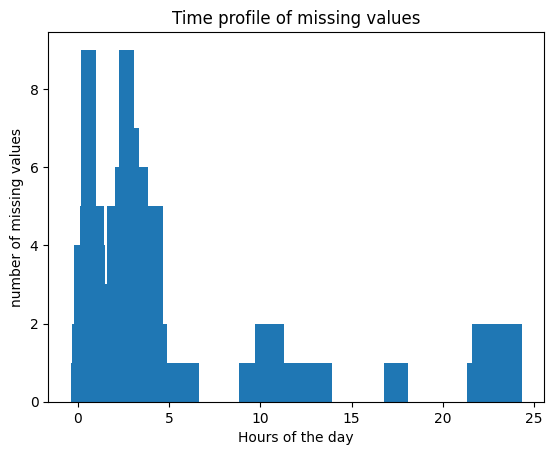

In [141]:
nans_per_time = np.sum(np.isnan(vectorized_day_dataset),0)
print(nans_per_time.shape)

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# Create an array 'x_axis' representing the 5-minute intervals
x_axis = np.arange(0, nintvals, 1, dtype=int)
# Initialize an empty list 'x_axis_hours' to store time values in hours
x_axis_hours = []
# Convert interval indices to hours and append them to 'x_axis_hours'
for i in range(0, len(x_axis)):
  x_axis_hours.append(float(x_axis[i]*5)/60)
ax.bar(x_axis_hours,height=nans_per_time)


ax.set_ylabel('number of missing values')
ax.set_xlabel('Hours of the day')
ax.set_title('Time profile of missing values')

plt.show()

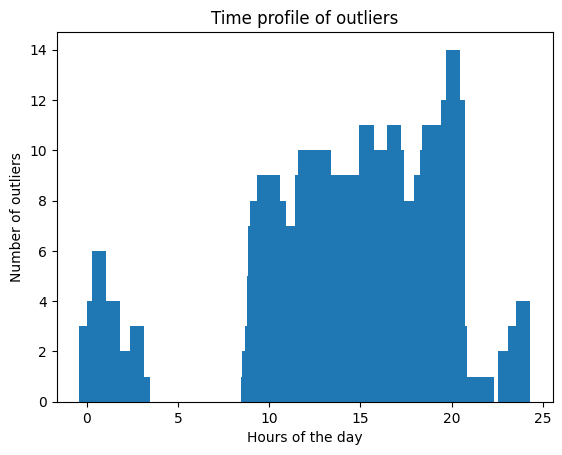

In [142]:
#graph for outliers
import numpy as np
# Count outliers per time interval (sum along axis 0, similar to NaN counting)
outliers_per_time = np.sum(outliers, 0)

# Plotting the number of outliers per time interval
fig, ax = plt.subplots()

# Create an array 'x_axis' representing the 5-minute intervals
x_axis = np.arange(0, nintvals, 1, dtype=int)

# Convert interval indices to hours
x_axis_hours = [float(i * 5) / 60 for i in x_axis]

# Plot the number of outliers for each time interval
ax.bar(x_axis_hours, height=outliers_per_time)

# Set the axis labels and title
ax.set_ylabel('Number of outliers')
ax.set_xlabel('Hours of the day')
ax.set_title('Time profile of outliers')

# Show the plot
plt.show()

Are these missing values associated with just a few days?

In [143]:
nans_per_day = np.sum(np.isnan(vectorized_day_dataset),1)
print('number of days with missing value',np.size(np.where(nans_per_day > 0),1))

number of days with missing value 28


What does the data look like? What is the traffic pattern? Below is the script that can help you visualize all days where overlapping transparencies highlight some patterns. The black line is the average yearly flow for a time interval.

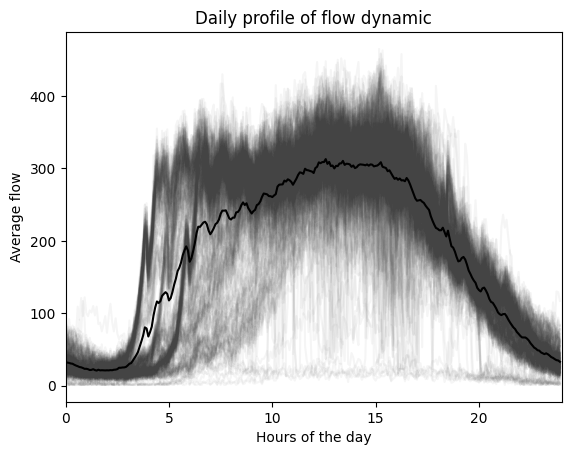

In [144]:
# Create a new figure and axis object using subplots
fig, ax = plt.subplots()# a convenient way to create a new figure and a set of subplots.
ax.plot(np.array([x_axis_hours,]*ndays).transpose(),vectorized_day_dataset.transpose(),color='#444444',alpha=0.05)
# Above line plots the dataset with specified color and transparency.
ax.plot(x_axis_hours,np.transpose(np.nanmean(vectorized_day_dataset,0)),color='black')
# Above line plots the average of the dataset in black color.

ax.set_ylabel('Average flow')
ax.set_xlabel('Hours of the day')
plt.xlim(0,24)
ax.set_title('Daily profile of flow dynamic')

plt.show()

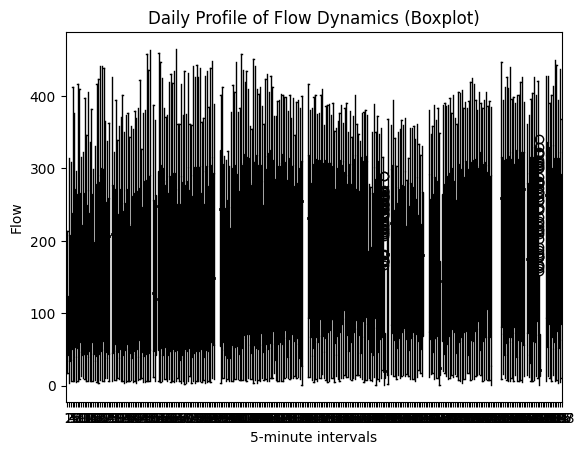

In [145]:
# Create a new figure and axis object using subplots
fig, ax = plt.subplots()  # This line is a convenient way to create a new figure and a set of subplots.

# Create a boxplot for the dataset
boxplot = ax.boxplot(vectorized_day_dataset.T, patch_artist=True)

# Customize the boxplot appearance
for patch in boxplot['boxes']:
    patch.set_facecolor('#444444')  # Set the box color to gray
for median in boxplot['medians']:
    median.set(color='black', linewidth=2)  # Set median line color to black

# Set the y-axis label
ax.set_ylabel('Flow')

# Set the x-axis label
ax.set_xlabel('5-minute intervals')

# Set the x-axis limits to be between 0 and 24
plt.xlim(0, 288)

# Set the title of the plot
ax.set_title('Daily Profile of Flow Dynamics (Boxplot)')

# Display the plot
plt.show()

Some patterns are obvious, and we could expect some peak and weekend patterns. Thus, a simple thing to do is look at day-of-week patterns, done below.

In [146]:
import datetime

# Create an array 'day_of_week' to store the day of the week for each unique date
day_of_week = np.zeros((ndays))

# Loop through each unique date
for i in range(0, ndays):
    # Parse the current date from a string to a datetime object
    day_dt = datetime.datetime.strptime(str(days[i]), '%Y%m%d')

    # Get the day of the week (1 for Monday, 2 for Tuesday, ..., 7 for Sunday)
    day_of_week[i] = day_dt.isoweekday()

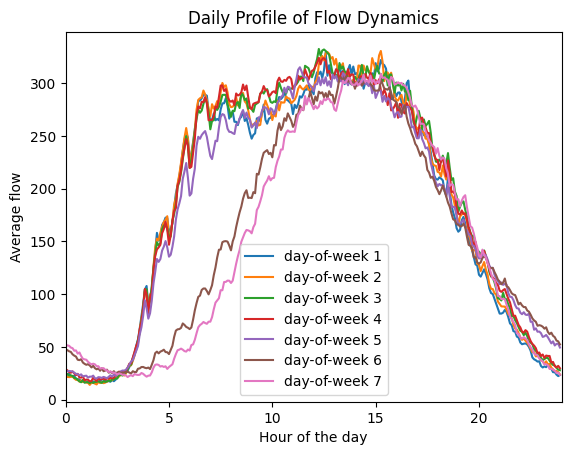

In [147]:
# Create a new figure and axis object using subplots
fig, ax = plt.subplots()

# Iterate through each day of the week (from 1 to 7)
for i in range(1, 8):
    # Find the indices of days that correspond to the current day of the week
    day_of_week_index_t = np.where(day_of_week == i)

    # Calculate the number of days that match the current day of the week
    ndays_t = np.size(day_of_week_index_t[0])

    # Plot the average flow for the current day of the week
    ax.plot(x_axis_hours,
            np.nanmean(vectorized_day_dataset[day_of_week_index_t[0], :].transpose(), 1),
            label='day-of-week ' + str(i))
    # This line plots the average flow for the current day of the week.
    # 'np.nanmean()' calculates the mean while handling NaN values.

# Set the y-axis label
ax.set_ylabel('Average flow')

# Set the x-axis label
ax.set_xlabel('Hour of the day')

# Set the x-axis limits to be between 0 and 24
plt.xlim(0, 24)

# Set the title of the plot
ax.set_title('Daily Profile of Flow Dynamics')

# Add a legend indicating the day of the week
ax.legend()

# Display the plot
plt.show()

The day's index is from 1 - 7, where 1 is Monday. To our expectations, we can see the difference between weekdays and weekends. However, some patterns from the previous plot are missing here and may include seasonal, holiday, and incident impacts on observations. This we explore with clustering in the next part of the exercise.

# Part 2: Clustering

In this part, you will work on revealing patterns using traffic observations and clustering methods.

## Clustering

Using clustering methods in scikit-learn is relatively simple, as shown below. With one line of code, you can get some clusters. However, this will need some work to search for representative clusters. This is the first step to pattern exploration.

In [148]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture

#clusters = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(vectorized_day_dataset)


As you can see k-means clustering method can not handle missing values, so you have choices: impute data or remove them. We will just remove all days that have missing observations. Fewer days would be removed if we restrict the clustering to a particular day-time period, 06:00 - 22:00:00. Below, we prepare a new dataset without missing values and update the list of days for later visualization purposes.

## Visualizaiton of representative day-type patterns

### Special plots for visualizing day-type patterns

the results of clusterings are assignments to the clusters, this can be hard to read and make conclusions about it, so visualization of data in right way is of high importance. Below script gives you set of libraries for calendar and centroid visualizaiton.

***Note: The below script you do not have to understand. Consider it as an external library that will plot for you, just like a histogram plot, for which you also do not know the exact implementation. Anyway, this course does not focus on information visualization.***

In [149]:

from dateutil.relativedelta import relativedelta
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
from matplotlib import gridspec
from matplotlib.patches import Patch
from matplotlib import colors

def assign_colors(n_clusters, days, assigments):

    days_colors = []
    color_to_cluster = []
    style_to_cluster = []
    weekend_colors = ['#67001f','#d6604d','#fdae61','#f46d43','#d53e4f','#9e0142','#f768a1','#f1c232']#,'#fe9929','#cc4c02','#e31a1c','#737373','#bdbdbd','#252525','#bcbddc']
#    weekend_school_colors = ['#c2a5cf','#f1b6da','#8e0152','#c51b7d','#de77ae','#ae017e','#fcc5c0','#e31a1c','#737373','#bdbdbd']
#    bank_holidays_colors = ['#543005','#dfc27d','#bf812d','#8c510a']
    mixed_colors = ['#4d4d4d','#35978f','#bababa','#878787']
    weekday_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#cab2d6','#6a3d9a','#b15928','#8dd3c7','#bebada','#fb8072','#b3de69','#bc80bd','#fccde5','#ccebc5','#35978f','#80cdc1']

    cluster_id_weekdays_share = []
    cluster_id_weekend_share = []
    cluster_id_all_days = []

    for i in range(0,n_clusters):
        color_to_cluster.append(None)
        style_to_cluster.append(None)
        cluster_id_weekdays_share.append(0)
        cluster_id_weekend_share.append(0)
        cluster_id_all_days.append(0)

    for i in range(0,len(days)):
        #print(i,assigments[i],len(assigments),len(cluster_id_all_days))
        if assigments[i] is not None:
            cluster_id_all_days[assigments[i]] += 1
            if '-' in str(days[i]):
                pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
            else:
                pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')

            if int(pomT.weekday()) < 5:
                cluster_id_weekdays_share[assigments[i]] += 1
            else:
                cluster_id_weekend_share[assigments[i]] += 1

    print('cluster_id_weekdays_share',cluster_id_weekdays_share)
    print('cluster_id_weekend_share',cluster_id_weekend_share)
    for i in range(0,len(days)):
        if assigments[i] is not None:
            cluster_idx = assigments[i]
            if '-' in str(days[i]):
                pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
            else:
                pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')
            if color_to_cluster[assigments[i]] is None:
                if cluster_id_weekend_share[cluster_idx] / float(cluster_id_all_days[cluster_idx]) > 0.6:
                        color_to_cluster[assigments[i]] = weekend_colors.pop()
                        style_to_cluster[assigments[i]] = ':'
                elif cluster_id_weekdays_share[cluster_idx] / float(cluster_id_all_days[cluster_idx]) > 0.6:
                        color_to_cluster[assigments[i]] = weekday_colors.pop(0)
                        style_to_cluster[assigments[i]] = '-'
                else:
                    color_to_cluster[assigments[i]] = mixed_colors.pop()
                    style_to_cluster[assigments[i]] = ':'

            days_colors.append(color_to_cluster[assigments[i]])
        else:
            days_colors.append(None)

    return days_colors,color_to_cluster,style_to_cluster


def calmap(ax, year, data, days, assigments, n_clusters,days_colors,color_to_cluster,
           limit_graphics=False):

    ax.tick_params('x', length=0, labelsize="medium", which='major')
    ax.tick_params('y', length=0, labelsize="x-small", which='major')

    # Month borders

    xticks, labels = [], []
    start = datetime.datetime(year,1,1).weekday()

    for month in range(1,13):

        first = datetime.datetime(year, month, 1)
        last = first + relativedelta(months=1, days=-1)

        y0 = first.weekday()
        y1 = last.weekday()
        x0 = (int(first.strftime("%j"))+start-1)//7
        x1 = (int(last.strftime("%j"))+start-1)//7

        P = [ (x0,   y0), (x0,    7),  (x1,   7),
              (x1,   y1+1), (x1+1,  y1+1), (x1+1, 0),
              (x0+1,  0), (x0+1,  y0) ]

        xticks.append(x0 +(x1-x0+1)/2)
        labels.append(first.strftime("%b"))
        poly = Polygon(P, edgecolor="black", facecolor="None",

                       linewidth=1, zorder=20, clip_on=False)

        ax.add_artist(poly)

    line = Line2D([0,53],[5,5],linewidth=1, zorder = 20,color="black",linestyle='dashed')
    ax.add_artist(line)

    if not limit_graphics:
        ax.set_xticks(xticks)
        ax.set_xticklabels(labels)
        ax.set_yticks(0.5 + np.arange(7))
        ax.set_yticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
        ax.set_title("{}".format(year), weight="semibold")
    else:
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        plt.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,         # ticks along the top edge are off
            labelleft=False)

    # Clearing first and last day from the data
    valid = datetime.datetime(year, 1, 1).weekday()
    data[:valid,0] = np.nan
    valid = datetime.datetime(year, 12, 31).weekday()
    # data[:,x1+1:] = np.nan
    data[valid+1:,x1] = np.nan

    for i in range(0,len(days)):
        if '-' in str(days[i]):
            pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
        else:
            pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')
        week_number = int(pomT.strftime("%W"))
        day_of_week = int(pomT.weekday())
        data[day_of_week,week_number] = assigments[i]


    act_date = datetime.datetime(year,1,1)
    while (act_date.year == year):

        week_number = int(act_date.strftime("%W"))
        day_of_week = int(act_date.weekday())
        doy_id = act_date.timetuple().tm_yday
        if doy_id<5 and week_number > 53:
            week_number = 0

        act_date = act_date + datetime.timedelta(days=1)

    #pomT = datetime.datetime.strptime('2017-01-01','%Y-%m-%d')
    #week_number = int(pomT.strftime("%V"))
    #day_of_week = int(pomT.weekday())
    #print(week_number,day_of_week)
    #doy_id = pomT.timetuple().tm_yday
    #if doy_id<5 and week_number > 0:
    #    week_number = 0
    #data[day_of_week,week_number] = len(clusters)+10

    # Showing data
    cmap = plt.cm.spring  # Can be any colormap that you want after the cm
    cmap.set_bad(color='white')

    #ax.imshow(data, extent=[0,53,0,7], zorder=10, vmin=0, vmax=len(clusters)+10,
    #          cmap=cmap, origin="lower", alpha=.75)

    cmap = colors.ListedColormap(color_to_cluster)
    bounds=[-0.1]
    step = 1
    for i in range(0,n_clusters):
        bounds.append(i-0.1+step)
    norm = colors.BoundaryNorm(bounds, cmap.N)
    #print(color_to_cluster)
   #print(bounds)
    #print(norm)

    #print(color_to_cluster)
    #print(bounds)
    #print(cmap)
    #exit(0)

    ax.imshow(data, extent=[0,53,0,7], zorder=10, interpolation='nearest', origin='lower',cmap=cmap, norm=norm)

def make_calendar_visualization_figure(days,assigments,n_clusters,years,days_colors,color_to_cluster,
                                       save_figure: str = None, show_figure:bool = True, limit_graphics = False):

    fig = plt.figure(figsize=(8,1.5*len(years)), dpi=100)
    X = np.linspace(-1,1, 53*7)

    for i, obj in enumerate(years):

        pom_s = str(len(years))+'1'+str(i+1)
        print(pom_s)

        ax = plt.subplot(int(pom_s), xlim=[0, 53], ylim=[0, 7], frameon=False, aspect=1)
        I = 1.2 - np.cos(X.ravel()) + np.random.normal(0,.2, X.size)
        I = I.reshape(53,7).T
        I.fill(np.nan)
        calmap(ax, int(obj), I.reshape(53,7).T, days, assigments, n_clusters,days_colors,color_to_cluster, limit_graphics)

    #   ax = plt.subplot(212, xlim=[0,53], ylim=[0,7], frameon=False, aspect=1)
    #  I = 1.1 - np.cos(X.ravel()) + np.random.normal(0,.2, X.size)
    #   calmap(ax, 2018, I.reshape(53,7).T)

    #ax = plt.subplot(313, xlim=[0,53], ylim=[0,7], frameon=False, aspect=1)
    #I = 1.0 - np.cos(X.ravel()) + np.random.normal(0,.2, X.size)
    #calmap(ax, 2019, I.reshape(53,7).T)
    if save_figure:
        plt.savefig(save_figure)

    if show_figure or save_figure is None:
        plt.tight_layout()
        plt.show()


def make_figure_centroids(x,y,color_to_cluster,style_to_cluster,cluster_ids,minY = None,maxY = None,
                          save_figure: str = None, show_figure:bool = True):

    #print(color_to_cluster)
    fig = plt.figure(figsize=(8,3))
    ax = fig.add_subplot(111)
    for i in range(0,len(x)):
        #print(i,color_to_cluster[i],style_to_cluster[i])
        #print(y[i])
        ax.plot(x[i],y[i],style_to_cluster[i], color=color_to_cluster[i], label=str(cluster_ids[i]))
    ax.set_xlabel('Time of day')
    ax.set_ylabel('Flow')
    if minY is not None and maxY is not None:
        ax.set_ylim([minY, maxY])
    plt.legend()

    if save_figure:
        plt.savefig(save_figure)

    if show_figure or save_figure is None:
        plt.tight_layout()
        plt.show()



# Best DBSCAN Model

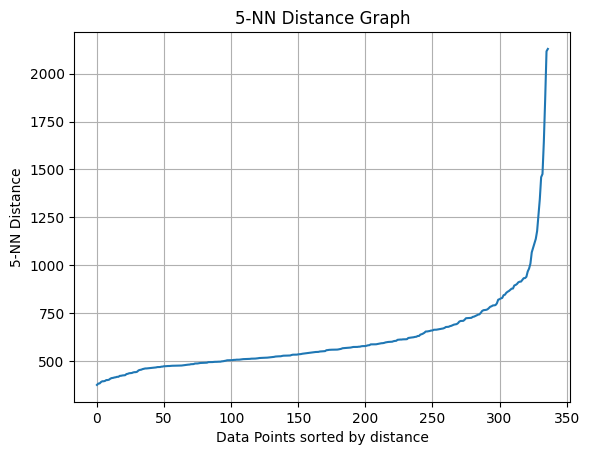

In [150]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

# Set the value of 'k' as the minimum samples for DBSCAN (which is 5)
k = 5

# Compute the nearest neighbors
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(vectorized_day_dataset_no_nans)
distances, indices = neighbors_fit.kneighbors(vectorized_day_dataset_no_nans)

# Sort the distances to the 5th nearest neighbor (distances[:, k-1])
distances_kth = np.sort(distances[:, k-1])

# Plot the k-NN distance graph
plt.plot(distances_kth)
plt.ylabel(f'{k}-NN Distance')
plt.xlabel('Data Points sorted by distance')
plt.title(f'{k}-NN Distance Graph')
plt.grid(True)
plt.show()

# Now you can visually check for an "elbow" in the plot and choose the appropriate eps value


In [151]:
n_clusters = 10
clusters = None
#print(np.where(nans_per_day > 0)[0])
vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0],:]
days_not_nans = days[np.where(nans_per_day == 0)[0]]

# BELOW lines enables you to comment in and out clustering method you want to use note that GMM have different ouput and thus labels are extracted differently
clusters = DBSCAN(eps=500, min_samples = 5).fit(vectorized_day_dataset_no_nans) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
# min smaple is 5 because there are four relevant dimensions in the database

if clusters is not None:
  cluster_labels = clusters.labels_

print(cluster_labels)

[-1  0  0 -1 -1  0 -1 -1  0  0 -1 -1 -1 -1 -1  0  0  1 -1  1  1  1  0  0
 -1 -1 -1  1  0  0 -1 -1 -1 -1 -1  0  0  1  1  1 -1 -1  0  0 -1  1  1 -1
  0  0  1 -1 -1 -1  0  0  1  1 -1  1 -1  0  0  1 -1  1 -1  1  0  0 -1  1
  1 -1  1  0  0  1 -1 -1 -1  1  0 -1 -1 -1  0  0  0 -1  1  1 -1  0  0 -1
  1  1 -1  1  0  0  1 -1  1  1 -1  0  0 -1  1 -1 -1 -1  0  2  4  4  4 -1
 -1  2  2 -1 -1 -1 -1  3  2  2 -1 -1  2  2 -1  4  4  4 -1  2  2 -1 -1 -1
  4 -1 -1  2  4  4 -1 -1 -1 -1  2 -1 -1  4  4 -1  2  2  4 -1 -1  4 -1 -1
  2 -1 -1 -1 -1 -1  2 -1 -1 -1  3  2  2  3  3 -1  3  3  2  2  3 -1  3  3
  3  2  2  3 -1  2  2  3 -1  3 -1  2  2 -1 -1 -1 -1 -1 -1  2  4 -1 -1 -1
 -1  2 -1 -1  4 -1 -1 -1 -1  2  4  4  4 -1 -1 -1 -1  2  2  4  4 -1  4 -1
  2  2  4  4 -1 -1 -1  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  4  4 -1
 -1 -1 -1  4  4 -1 -1  2 -1 -1 -1 -1 -1  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1  0 -1 -1 -1 -1 -1 -1  0  0 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1  0 -1
 -1 -1 -1 -1  0  0 -1 -1 -1 -1 -1  0  0 -1 -1 -1 -1

6
cluster_id_weekdays_share [2, 31, 3, 13, 27, 160]
cluster_id_weekend_share [44, 0, 35, 0, 0, 22]
111


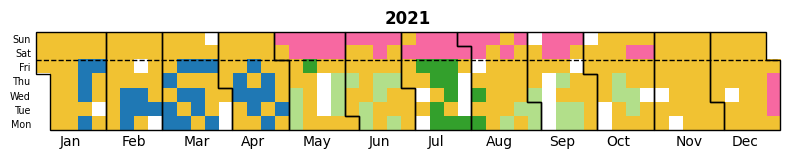

In [152]:
# Calculate the number of clusters by finding unique values in 'cluster_labels'
n_clusters_t = len(np.unique(cluster_labels))
print(n_clusters_t)
# Assign colors to days based on clusters
days_colors, color_to_cluster, style_to_cluster = assign_colors(n_clusters_t, days_not_nans, cluster_labels)
# The function 'assign_colors' is used to determine colors and styles for visualization.

# Create a calendar visualization figure
make_calendar_visualization_figure(days_not_nans, cluster_labels, n_clusters_t, [2021], days_colors,
                                   color_to_cluster, save_figure=None)


#### Day-time profile of centroids

<ipython-input-153-5398d35fc353>:12: RuntimeWarning: Mean of empty slice
  centroid_yy = list(np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i)[0], :], 0).transpose())


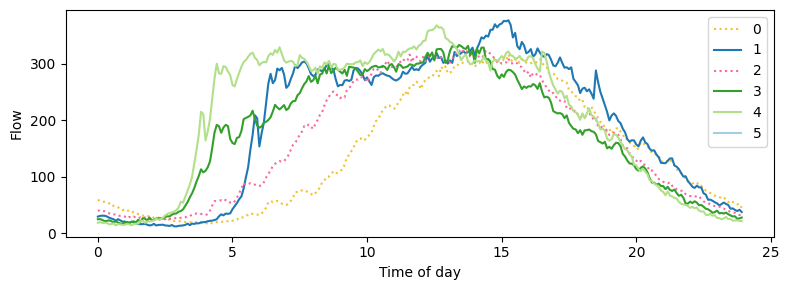

In [153]:
# Initialize empty lists to store centroid data
centroids_xx = []  # x-axis values for centroids
centroids_yy_daytypes = []  # y-axis values for centroids, grouped by day types
cluster_ids = []  # Cluster IDs

# Iterate through each cluster
for i in range(0, n_clusters_t):
    # Store the x-axis values for centroids (hours of the day)
    centroids_xx.append(x_axis_hours)

    # Calculate the y-axis values for centroids (average flow for each 5-minute interval)
    centroid_yy = list(np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i)[0], :], 0).transpose())
    centroids_yy_daytypes.append(centroid_yy)

    # Store the cluster ID
    cluster_ids.append(i)

# Generate a figure displaying the centroids
make_figure_centroids(centroids_xx, centroids_yy_daytypes, color_to_cluster, style_to_cluster, cluster_ids)
# The function 'make_figure_centroids' is used to create a visualization of the centroids,
# with the provided data and parameters.

# Best GGM Model

In [154]:
n_clusters = 10
clusters = None
#print(np.where(nans_per_day > 0)[0])
vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0],:]
days_not_nans = days[np.where(nans_per_day == 0)[0]]

# BELOW lines enables you to comment in and out clustering method you want to use note that GMM have different ouput and thus labels are extracted differently
#clusters = DBSCAN(eps=500, min_samples = 5).fit(vectorized_day_dataset_no_nans) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
# min smaple is 5 because there are four relevant dimensions in the database

if clusters is not None:
  cluster_labels = clusters.labels_

cluster_labels = GaussianMixture(n_components=n_clusters).fit(vectorized_day_dataset_no_nans).predict(vectorized_day_dataset_no_nans) #check the parameters at  https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_init.html#sphx-glr-auto-examples-mixture-plot-gmm-init-py


print(cluster_labels)

[7 7 7 2 9 7 0 0 7 7 2 2 2 2 2 7 7 0 0 0 0 0 3 7 2 0 2 0 7 7 2 2 2 0 0 7 7
 2 0 0 2 0 3 7 0 0 0 0 3 3 0 0 0 0 3 3 0 0 0 0 2 3 3 0 0 0 2 0 3 3 0 0 0 0
 0 3 3 0 0 0 0 0 3 0 0 3 7 3 7 2 0 0 0 3 3 0 0 0 0 0 3 3 0 0 0 0 0 3 3 0 0
 0 0 0 3 9 8 8 8 8 8 9 9 8 8 1 2 4 9 9 8 8 9 9 8 8 8 8 8 9 9 8 8 1 8 1 2 9
 8 8 1 1 1 2 9 8 1 8 8 4 2 9 8 8 1 1 2 7 9 1 4 8 1 4 2 5 4 1 4 2 2 4 4 4 4
 4 2 2 4 4 4 4 4 2 2 4 4 2 9 4 4 4 5 9 9 4 4 4 8 4 2 9 8 8 8 8 1 9 9 8 8 8
 8 1 9 9 8 8 8 8 1 9 8 9 9 8 8 1 8 8 9 9 8 8 8 8 9 9 8 8 8 8 8 5 8 8 8 9 9
 8 8 8 8 1 2 9 8 8 8 1 4 9 9 1 8 8 8 9 3 6 6 6 6 3 3 6 6 6 6 9 3 6 6 6 6 6
 3 3 6 6 6 6 6 3 3 6 6 6 6 6 3 3 6 6 6 2 3 3 6 6 6 6 6 3 3 6 6 6 2 7 7 7 2
 9 9 9 7]


10
cluster_id_weekdays_share [60, 19, 21, 1, 26, 1, 34, 5, 65, 4]
cluster_id_weekend_share [0, 0, 13, 35, 0, 2, 0, 16, 0, 35]
111


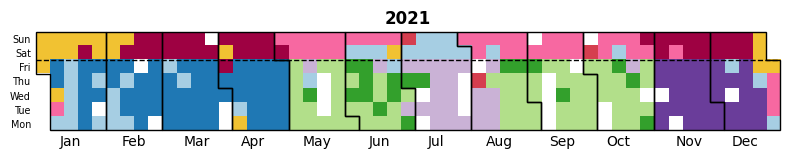

In [155]:
# Calculate the number of clusters by finding unique values in 'cluster_labels'
n_clusters_t = len(np.unique(cluster_labels))
print(n_clusters_t)
# Assign colors to days based on clusters
days_colors, color_to_cluster, style_to_cluster = assign_colors(n_clusters_t, days_not_nans, cluster_labels)
# The function 'assign_colors' is used to determine colors and styles for visualization.

# Create a calendar visualization figure
make_calendar_visualization_figure(days_not_nans, cluster_labels, n_clusters_t, [2021], days_colors,
                                   color_to_cluster, save_figure=None)
# This function 'make_calendar_visualization_figure' is used to generate a visualization based on the provided data and parameters.
# 'days_not_nans' are the days, 'cluster_labels' are the cluster labels, 'n_clusters_t' is the number of clusters,
# '[2021]' represents the year, 'days_colors' represent the assigned colors for each day, 'color_to_cluster' maps colors to clusters,
# and 'save_figure' is an optional parameter to save the generated figure (can be None if not saving).

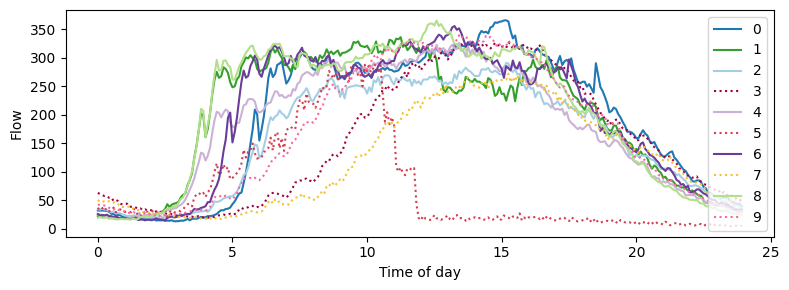

In [156]:
# Initialize empty lists to store centroid data
centroids_xx = []  # x-axis values for centroids
centroids_yy_daytypes = []  # y-axis values for centroids, grouped by day types
cluster_ids = []  # Cluster IDs

# Iterate through each cluster
for i in range(0, n_clusters_t):
    # Store the x-axis values for centroids (hours of the day)
    centroids_xx.append(x_axis_hours)

    # Calculate the y-axis values for centroids (average flow for each 5-minute interval)
    centroid_yy = list(np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i)[0], :], 0).transpose())
    centroids_yy_daytypes.append(centroid_yy)

    # Store the cluster ID
    cluster_ids.append(i)

# Generate a figure displaying the centroids
make_figure_centroids(centroids_xx, centroids_yy_daytypes, color_to_cluster, style_to_cluster, cluster_ids)
# The function 'make_figure_centroids' is used to create a visualization of the centroids,
# with the provided data and parameters.

# Best KMeans model
This code will help to find the best parameters for the KMeans model based on the internal evaluation scores.

In [157]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score

# Assuming vectorized_day_dataset_no_nans and days_not_nans are already defined
vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0], :]
days_not_nans = days[np.where(nans_per_day == 0)[0]]

# Function to calculate clustering evaluation scores on the full dataset
def evaluate_clustering(cluster_labels, data):
    SC_score = silhouette_score(data, cluster_labels)
    DB_score = davies_bouldin_score(data, cluster_labels)
    CH_score = calinski_harabasz_score(data, cluster_labels)

    return {'SC': SC_score, 'DB': DB_score, 'CH': CH_score}

# KMeans parameters for grid search
kmeans_params = {
    'n_clusters': [5, 7, 10, 12],
    'init': ['k-means++', 'random'],
    'n_init': ['auto'],
    'algorithm': ['lloyd', 'elkan'],
    'random_state': [0]
}

# To store the best parameters and scores
best_params = None
best_scores = {'SC': -np.inf, 'DB': np.inf, 'CH': -np.inf}
best_combined_score = -np.inf  # To track the best combined score (higher is better)

# Grid search for KMeans on the full dataset
for n_clusters in kmeans_params['n_clusters']:
    for init in kmeans_params['init']:
        for n_init in kmeans_params['n_init']:
            for algorithm in kmeans_params['algorithm']:
                kmeans = KMeans(
                    n_clusters=n_clusters,
                    init=init,
                    n_init=n_init,
                    algorithm=algorithm,
                    random_state=0
                )

                # Fit the model on the full dataset
                kmeans.fit(vectorized_day_dataset_no_nans)

                # Get the cluster labels for the full dataset
                cluster_labels = kmeans.labels_

                # Evaluate the current KMeans configuration on the full dataset
                model_name = f"KMeans (n_clusters={n_clusters}, init={init}, n_init={n_init}, algorithm={algorithm})"
                scores = evaluate_clustering(cluster_labels, vectorized_day_dataset_no_nans)

                # Calculate a combined score based on Silhouette, Davies-Bouldin, and Calinski-Harabasz scores
                combined_score = scores['CH']  # You could use a different metric or a weighted average here

                # If the combined score is better, update best parameters and scores
                if combined_score > best_combined_score:
                    best_combined_score = combined_score
                    best_params = {'n_clusters': n_clusters, 'init': init, 'n_init': n_init, 'algorithm': algorithm}
                    best_scores = scores

                # Print results for the full dataset
                print(f"Model: {model_name}")
                print(f"Full Dataset - Silhouette Score: {scores['SC']}, Davies-Bouldin Score: {scores['DB']}, Calinski-Harabasz Score: {scores['CH']}\n")

# Print the best parameters and their evaluation scores
print("Best Parameters for KMeans:")
print(best_params)
print("Best Scores for Full Dataset:")
print(f"Silhouette Score: {best_scores['SC']}, Davies-Bouldin Score: {best_scores['DB']}, Calinski-Harabasz Score: {best_scores['CH']}")


Model: KMeans (n_clusters=5, init=k-means++, n_init=auto, algorithm=lloyd)
Full Dataset - Silhouette Score: 0.22969753927464953, Davies-Bouldin Score: 1.5158295908096302, Calinski-Harabasz Score: 114.69473802964785

Model: KMeans (n_clusters=5, init=k-means++, n_init=auto, algorithm=elkan)
Full Dataset - Silhouette Score: 0.22969753927464953, Davies-Bouldin Score: 1.5158295908096302, Calinski-Harabasz Score: 114.69473802964785

Model: KMeans (n_clusters=5, init=random, n_init=auto, algorithm=lloyd)
Full Dataset - Silhouette Score: 0.2690491034806728, Davies-Bouldin Score: 1.2284142488483722, Calinski-Harabasz Score: 123.3820360585625

Model: KMeans (n_clusters=5, init=random, n_init=auto, algorithm=elkan)
Full Dataset - Silhouette Score: 0.2690491034806728, Davies-Bouldin Score: 1.2284142488483722, Calinski-Harabasz Score: 123.3820360585625

Model: KMeans (n_clusters=7, init=k-means++, n_init=auto, algorithm=lloyd)
Full Dataset - Silhouette Score: 0.24133229796735856, Davies-Bouldin Sc

The best parameters for teh KMean model according to the gridsearch are 'n_clusters': 5, 'init': 'random', 'n_init': 'auto', 'algorithm': 'lloyd'. this determination is based on only the average silhoutte score over the test and train data.

Number of Clusters: 5
cluster_id_weekdays_share [19, 1, 76, 6, 134]
cluster_id_weekend_share [52, 2, 0, 47, 0]
111


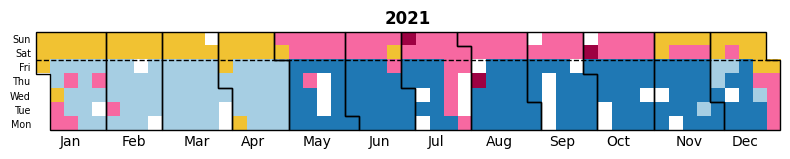

In [158]:
import numpy as np
from sklearn.cluster import KMeans

# Fit KMeans using the best parameters on the entire dataset (or train dataset, depending on your use case)
kmeans = KMeans(
    n_clusters=best_params['n_clusters'],
    init=best_params['init'],
    n_init=best_params['n_init'],
    algorithm=best_params['algorithm'],
)

# Fit the KMeans model to the data (using either the full dataset or the training set)
kmeans.fit(vectorized_day_dataset_no_nans)  # Replace with your final dataset

# Extract cluster labels
cluster_labels = kmeans.labels_

# Calculate the number of clusters based on the unique labels in 'cluster_labels'
n_clusters_t = len(np.unique(cluster_labels))
print(f"Number of Clusters: {n_clusters_t}")

# Assign colors to days based on clusters
days_colors, color_to_cluster, style_to_cluster = assign_colors(n_clusters_t, days_not_nans, cluster_labels)

# Create a calendar visualization figure
make_calendar_visualization_figure(days_not_nans, cluster_labels, n_clusters_t, [2021], days_colors,
                                   color_to_cluster, save_figure=None)

# The function 'make_calendar_visualization_figure' will generate a calendar visualization based on the clustered days.


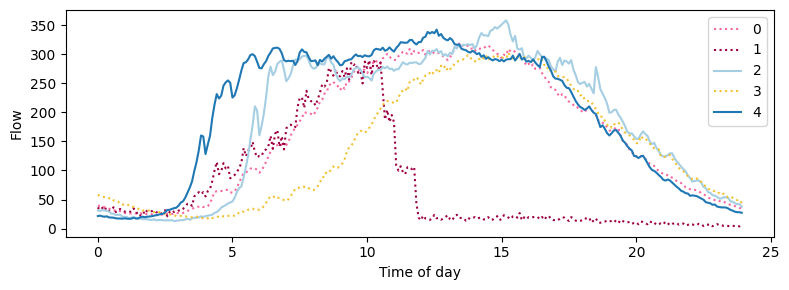

In [159]:
# Initialize empty lists to store centroid data
centroids_xx = []  # x-axis values for centroids
centroids_yy_daytypes = []  # y-axis values for centroids, grouped by day types
cluster_ids = []  # Cluster IDs

# Iterate through each cluster
for i in range(0, n_clusters_t):
    # Store the x-axis values for centroids (hours of the day)
    centroids_xx.append(x_axis_hours)

    # Calculate the y-axis values for centroids (average flow for each 5-minute interval)
    centroid_yy = list(np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i)[0], :], 0).transpose())
    centroids_yy_daytypes.append(centroid_yy)

    # Store the cluster ID
    cluster_ids.append(i)

# Generate a figure displaying the centroids
make_figure_centroids(centroids_xx, centroids_yy_daytypes, color_to_cluster, style_to_cluster, cluster_ids)
# The function 'make_figure_centroids' is used to create a visualization of the centroids,
# with the provided data and parameters.

Looking at the clusters, there is a clear difference between weekdays and weekend days, seasons and holidays. However, due to the number of clusters being 5, there is limited room for differences between weekdays.

# Best Agglomerative model


In [160]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score

# Assuming vectorized_day_dataset_no_nans and days_not_nans are already defined
vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0], :]
days_not_nans = days[np.where(nans_per_day == 0)[0]]

# Function to calculate clustering evaluation scores on the full dataset
def evaluate_clustering(cluster_labels, data):
    SC_score = silhouette_score(data, cluster_labels)
    DB_score = davies_bouldin_score(data, cluster_labels)
    CH_score = calinski_harabasz_score(data, cluster_labels)

    return {'SC': SC_score, 'DB': DB_score, 'CH': CH_score}

# Agglomerative Clustering parameters for grid search
agglomerative_params = {
    'n_clusters': [5, 7, 10, 12],
    'metric': ['euclidean', 'manhattan'],  # Different distance metrics
    'linkage': ['ward', 'complete', 'average']  # Different linkage criteria
}

# To store the best parameters and scores
best_params_AG = None
best_scores_AG = {'SC': -np.inf, 'DB': np.inf, 'CH': -np.inf}
best_combined_score_AG = -np.inf  # To track the best combined score (higher is better)

# Grid search for Agglomerative Clustering on the full dataset
for n_clusters in agglomerative_params['n_clusters']:
    for metric in agglomerative_params['metric']:
        for linkage in agglomerative_params['linkage']:
            # 'ward' linkage requires 'euclidean' metric
            if linkage == 'ward' and metric != 'euclidean':
                continue  # Skip invalid combination

            # Initialize AgglomerativeClustering model
            agglomerative = AgglomerativeClustering(
                n_clusters=n_clusters,
                affinity=metric,
                linkage=linkage
            )

            # Fit the model on the full dataset
            cluster_labels = agglomerative.fit_predict(vectorized_day_dataset_no_nans)

            # Evaluate the current AgglomerativeClustering configuration on the full dataset
            model_name = f"Agglomerative (n_clusters={n_clusters}, metric={metric}, linkage={linkage})"
            scores_AG = evaluate_clustering(cluster_labels, vectorized_day_dataset_no_nans)

            # Calculate the combined score (using Calinski-Harabasz score here, but you could change this)
            combined_score_AG = scores_AG['CH']

            # If the combined score is better, update best parameters and scores
            if combined_score_AG > best_combined_score_AG:
                best_combined_score_AG = combined_score_AG
                best_params_AG = {'n_clusters': n_clusters, 'metric': metric, 'linkage': linkage}
                best_scores_AG = scores_AG

            # Print results for the full dataset
            print(f"Model: {model_name}")
            print(f"Full Dataset - Silhouette Score: {scores_AG['SC']}, Davies-Bouldin Score: {scores_AG['DB']}, Calinski-Harabasz Score: {scores_AG['CH']}\n")

# Print the best parameters and their evaluation scores
print("Best Parameters for Agglomerative Clustering:")
print(best_params_AG)
print("Best Scores for Full Dataset:")
print(f"Silhouette Score: {best_scores_AG['SC']}, Davies-Bouldin Score: {best_scores_AG['DB']}, Calinski-Harabasz Score: {best_scores_AG['CH']}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and wi

Model: Agglomerative (n_clusters=5, metric=euclidean, linkage=ward)
Full Dataset - Silhouette Score: 0.26377798541725606, Davies-Bouldin Score: 1.2314039157719159, Calinski-Harabasz Score: 118.05469625253788

Model: Agglomerative (n_clusters=5, metric=euclidean, linkage=complete)
Full Dataset - Silhouette Score: 0.291094296577572, Davies-Bouldin Score: 1.0693313191628904, Calinski-Harabasz Score: 101.6989814682412

Model: Agglomerative (n_clusters=5, metric=euclidean, linkage=average)
Full Dataset - Silhouette Score: 0.22425245384415046, Davies-Bouldin Score: 0.5880467061171419, Calinski-Harabasz Score: 7.324087144856243

Model: Agglomerative (n_clusters=5, metric=manhattan, linkage=complete)
Full Dataset - Silhouette Score: 0.24866839027660897, Davies-Bouldin Score: 1.1120525376701882, Calinski-Harabasz Score: 100.49124461131792

Model: Agglomerative (n_clusters=5, metric=manhattan, linkage=average)
Full Dataset - Silhouette Score: 0.21355395207106947, Davies-Bouldin Score: 0.66801606

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and wi

Model: Agglomerative (n_clusters=10, metric=euclidean, linkage=complete)
Full Dataset - Silhouette Score: 0.22435851589172387, Davies-Bouldin Score: 1.1005438641422969, Calinski-Harabasz Score: 56.13081675794154

Model: Agglomerative (n_clusters=10, metric=euclidean, linkage=average)
Full Dataset - Silhouette Score: 0.26804898521189274, Davies-Bouldin Score: 0.7634697993367069, Calinski-Harabasz Score: 51.205896114225624

Model: Agglomerative (n_clusters=10, metric=manhattan, linkage=complete)
Full Dataset - Silhouette Score: 0.2114433401470397, Davies-Bouldin Score: 1.157206063774245, Calinski-Harabasz Score: 66.64686842387489

Model: Agglomerative (n_clusters=10, metric=manhattan, linkage=average)
Full Dataset - Silhouette Score: 0.23070863137230643, Davies-Bouldin Score: 0.8872277326481715, Calinski-Harabasz Score: 48.53560163390427

Model: Agglomerative (n_clusters=12, metric=euclidean, linkage=ward)
Full Dataset - Silhouette Score: 0.17341463378355707, Davies-Bouldin Score: 1.7937

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and wi

Model: Agglomerative (n_clusters=12, metric=euclidean, linkage=average)
Full Dataset - Silhouette Score: 0.2445782429089378, Davies-Bouldin Score: 0.7283128609079216, Calinski-Harabasz Score: 42.966940656938434

Model: Agglomerative (n_clusters=12, metric=manhattan, linkage=complete)
Full Dataset - Silhouette Score: 0.16132113570565773, Davies-Bouldin Score: 1.4594179922921435, Calinski-Harabasz Score: 65.23916835370329

Model: Agglomerative (n_clusters=12, metric=manhattan, linkage=average)
Full Dataset - Silhouette Score: 0.22289591507843715, Davies-Bouldin Score: 0.8195982489804942, Calinski-Harabasz Score: 41.960283764047745

Best Parameters for Agglomerative Clustering:
{'n_clusters': 5, 'metric': 'euclidean', 'linkage': 'ward'}
Best Scores for Full Dataset:
Silhouette Score: 0.26377798541725606, Davies-Bouldin Score: 1.2314039157719159, Calinski-Harabasz Score: 118.05469625253788


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


tekst

Number of Clusters: 5
cluster_id_weekdays_share [128, 30, 6, 71, 1]
cluster_id_weekend_share [0, 53, 46, 0, 2]
111


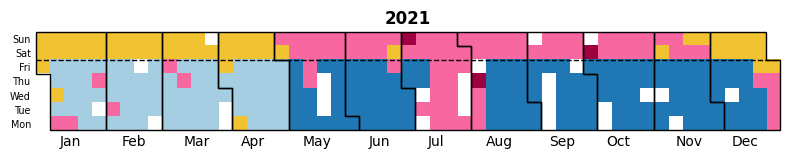

In [161]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering

# Fit AgglomerativeClustering using the best parameters on the entire dataset (or train dataset, depending on your use case)
agg_clustering = AgglomerativeClustering(
    n_clusters=best_params_AG['n_clusters'],  # Number of clusters
    metric=best_params_AG['metric'],      # Distance metric
    linkage=best_params_AG['linkage'],        # Linkage criterion
)

# Fit the AgglomerativeClustering model to the data (using either the full dataset or the training set)
agg_clustering.fit(vectorized_day_dataset_no_nans)  # Replace with your final dataset

# Extract cluster labels
cluster_labels = agg_clustering.labels_

# Calculate the number of clusters based on the unique labels in 'cluster_labels'
n_clusters_t = len(np.unique(cluster_labels))
print(f"Number of Clusters: {n_clusters_t}")

# Assign colors to days based on clusters
days_colors, color_to_cluster, style_to_cluster = assign_colors(n_clusters_t, days_not_nans, cluster_labels)

# Create a calendar visualization figure
make_calendar_visualization_figure(days_not_nans, cluster_labels, n_clusters_t, [2021], days_colors,
                                   color_to_cluster, save_figure=None)

# The function 'make_calendar_visualization_figure' will generate a calendar visualization based on the clustered days.


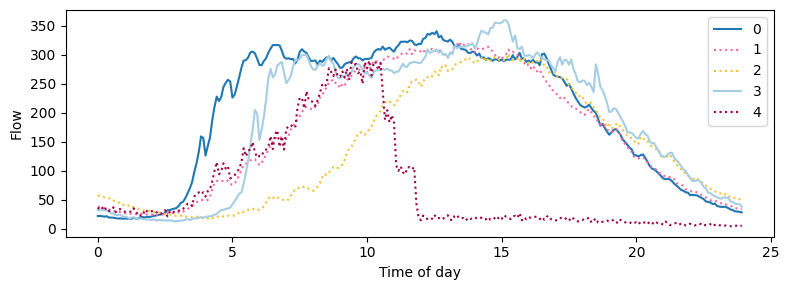

In [162]:
# Initialize empty lists to store centroid data
centroids_xx = []  # x-axis values for centroids
centroids_yy_daytypes = []  # y-axis values for centroids, grouped by day types
cluster_ids = []  # Cluster IDs

# Iterate through each cluster
for i in range(0, n_clusters_t):
    # Store the x-axis values for centroids (hours of the day)
    centroids_xx.append(x_axis_hours)

    # Calculate the y-axis values for centroids (average flow for each 5-minute interval)
    centroid_yy = list(np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i)[0], :], 0).transpose())
    centroids_yy_daytypes.append(centroid_yy)

    # Store the cluster ID
    cluster_ids.append(i)

# Generate a figure displaying the centroids
make_figure_centroids(centroids_xx, centroids_yy_daytypes, color_to_cluster, style_to_cluster, cluster_ids)
# The function 'make_figure_centroids' is used to create a visualization of the centroids,
# with the provided data and parameters.